### Step 1
Activate the Plastid conda environment and open up a Jupyter Lab session (alternatively, a python file can be run in this conda environment)

### Step 2
Load in all of the necessary Python packages.

In [1]:
# Load up the necessary packages 
import numpy as np
import pandas as pd
import dif_utils as dif
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
# Define the path to our data files and the path we want to save our outputs in. 
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Fmr1_targets/'
ks_dmel_path = '/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/KS_stats/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
samp_num = '2'

### Step 3
Load up a table containing a list of targets for your mutant gene and load up the KS table you created during the previous section using pandas pd.read_csv().

In [3]:
# Load up the target gene names. 
Fmr1_table = pd.read_csv(target_path + 'Fmr1_dmel_downreg_genes.txt', names = ["gene_name"])

# Load up the tables of KS statistics
df_dmel = pd.read_csv(ks_dmel_path + "ks_table_" + samp_num + ".csv")

### Step 4
Merge the table of KS statistics and the table of targets into a new table using pd.merge()

In [4]:
# Merge the ecoli ks table with the list of gene names
Fmr1_ks_table = pd.merge(df_dmel, Fmr1_table, how='inner', right_on='gene_name', left_on='gene_ID')

combo_df = pd.merge(df_dmel, Fmr1_table, how='left', right_on='gene_name', left_on='gene_ID')

### Step 5
Clean up your new table by removing any duplicates that may have been caused by multiple transcripts having the same gene name. 

In [5]:
# Keep only one copy of each gene in the Fmr1 table. 
Fmr1_ks_table.drop_duplicates(subset ="gene_name",keep = "first", inplace = True) 

df_dmel.drop_duplicates(subset ="gene_ID",keep = "first", inplace = True) 

combo_df.drop_duplicates(subset ="gene_ID",keep = "first", inplace = True) 

# Sort the data from lowest to highest and reset table index. 
combo_df = combo_df.sort_values(by = "ks_stat")
combo_df = combo_df.reset_index(drop = True)

### Step 6
Look at the KS statistic from the control mutant comparisons for all genes and for just the Fmr1 targets. This will help you get an initial sense for how you want to divide up the low, medium, and high KS fractions. For both the merged table and the original table of KS statistics, sort the KS values from smallest to largest using the sorted() function and then plot them as a scatter plot.

In [7]:
targets = combo_df.dropna()

non_targets = combo_df[combo_df["gene_name"].isnull()]

(0.0, 0.7)

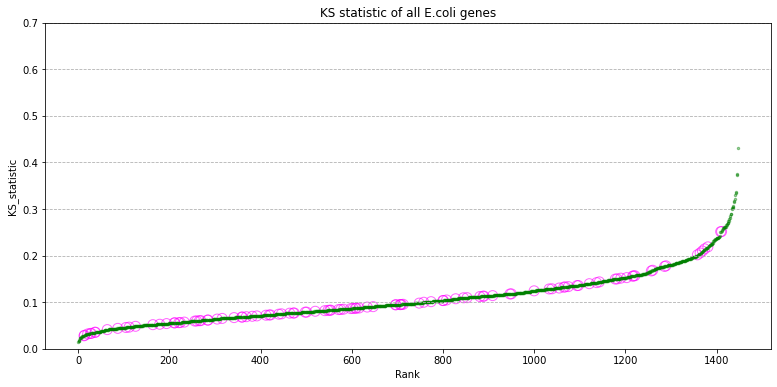

In [8]:
figure(figsize = (13,6))
plt.scatter(list(targets.index), targets["ks_stat"], s=100, alpha = 0.6, facecolors = 'none', edgecolors = 'magenta')
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all EFP targets")
plt.ylim(0,0.7)

plt.scatter(list(non_targets.index), non_targets["ks_stat"], s=6, alpha = 0.4, color = "g")
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all E.coli genes")
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.ylim(0,0.7)

### Step 7
Calculate the upper KS statistic by taking the average KS stat of the top 10% of transcripts with the highest KS stat. transcripts that have a higher KS statistic then the upper KS statistic will be within the high KS fraction. Then we choose the number of fractions we would like to observe. Then we use the determine_enrichment() function to determine the ratio between the targets and the total genes within each KS fraction.

In [9]:
# Calculate the proportion of genes which are Fmr1 targets in a high, medium, and low KS fraction
upper_ks = 0.3
N_cats = 2
enrich_dmel, sections_dmel = dif.determine_enrichment(targets, non_targets, upper_ks, N_cats)

### Step 8
Use matplotlib.pyplot.bar() function to create a series of barplots that show the observed percentage of genes that are targets in each fraction. Then you can draw a a line through this barplot using matplotlib.pyplot.plot() that shows the expected percentage of genes that are targets if there is no enrichment.  

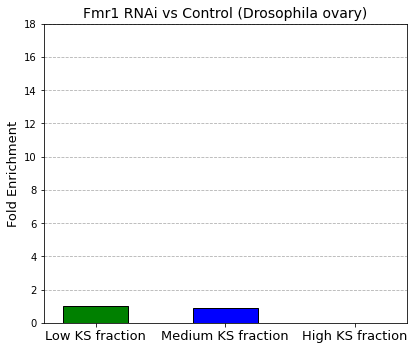

In [15]:
# Create a bar plot that shows the proportion of genes which are Fmr1 targets in each KS fraction.
figure(figsize = (6.5,5.5))
plt.bar([1,2,3],enrich_dmel, width = 0.5,
        tick_label = ["Low KS fraction","Medium KS fraction","High KS fraction"], 
       color = ["g", 'b', 'm'], edgecolor = 'black')
plt.xticks(fontsize = 13)
plt.xlim(0.6,3.4)
plt.ylim(0, 18)
plt.ylabel("Fold Enrichment", fontsize = 13)
plt.title("Fmr1 RNAi vs Control (Drosophila ovary)", fontsize = 14)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

### Step 9
Now we want to perform Fisher's exact test to determine if the difference between our observed and expected target proportions are significant. We can use the Fisher_exact_p_values() function to automatically calculate these P-values for each of the KS fractions.

In [11]:
# determine if the difference betwqeen the expected proportion of targets 
# and the observed proportion of targets is significant
dif.Fisher_exact_p_values(Fmr1_ks_table, df_dmel, sections_dmel)

[0.5217150045651058, 0.6951060207876103, 0.6166908381430509]